In [1]:
from __future__ import print_function

import cv2

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

(-0.5, 430.5, 473.5, -0.5)

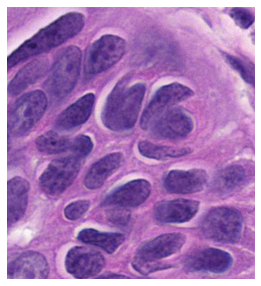

In [2]:
inputImageFile = "Abnormal variation in nuclear shape/1.png"

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
plt.axis("off")

In [3]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


In [4]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


Estimated stain colors (rows):
[[0.26735574 0.90087746 0.34196595]
 [0.5756765  0.75387876 0.31664394]]


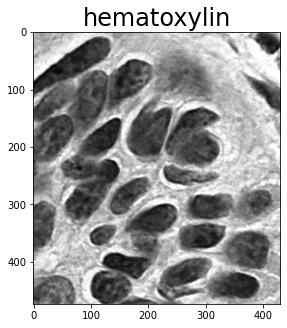

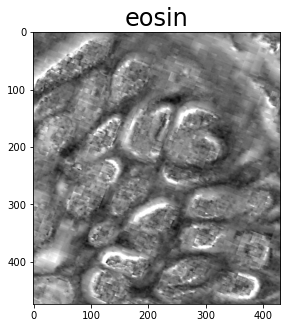

In [5]:
I_0 = 255

w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)

# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)

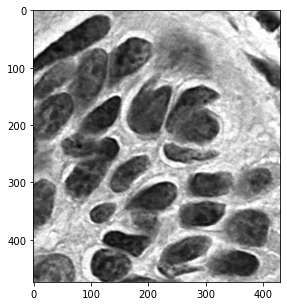

In [6]:
plt.imshow(deconv_result.Stains[:, :, 1])

In [7]:
H = deconv_result.Stains[:, :, 1]

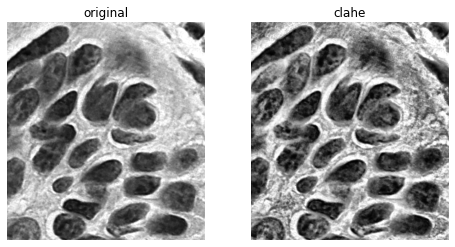

In [8]:
clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize=(8,8))
cl_img = clahe.apply(H)

plot_comparison(H, cl_img, 'clahe')

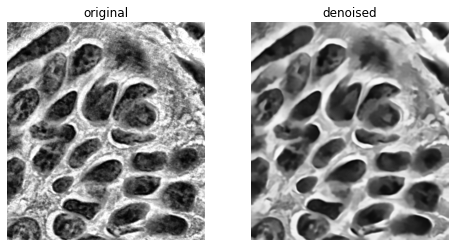

In [9]:
dst = cv2.fastNlMeansDenoising(cl_img, None, 30, 7, 21);

plot_comparison(cl_img, dst, 'denoised')

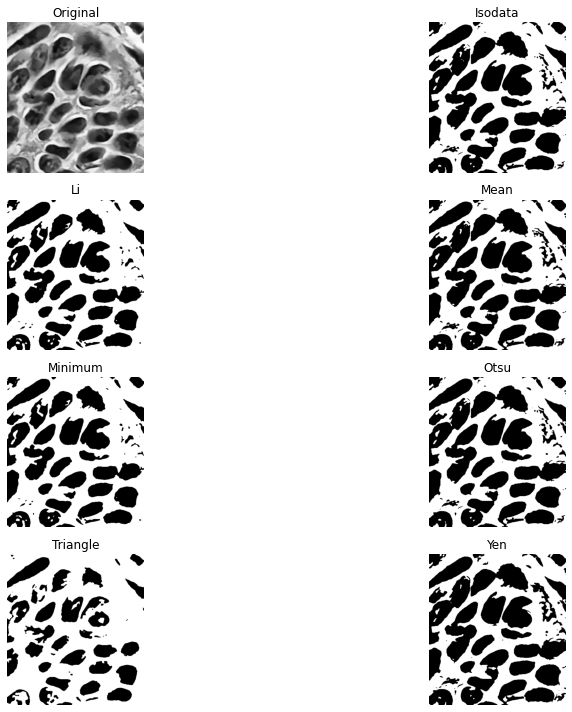

In [10]:
#Test filter

from skimage.filters import try_all_threshold

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(dst, figsize=(16, 10), verbose=False)
plt.show()

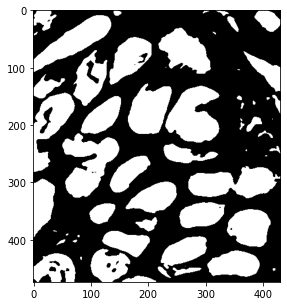

In [15]:
from skimage.filters import threshold_li

thresh = threshold_li(dst)
binary = dst > thresh

inverted = ~binary
inverted = inverted.astype(np.uint8)
inverted = inverted*255

plt.imshow(inverted)

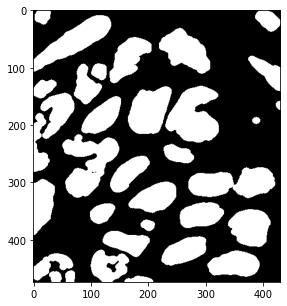

In [17]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
opening = cv2.morphologyEx(inverted, cv2.MORPH_OPEN, kernel)

plt.imshow(opening)

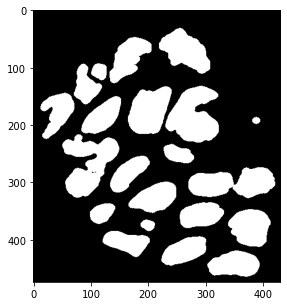

In [18]:
# Remove edge touching grains
opening = clear_border(opening)

plt.imshow(opening)

In [24]:
# sure background area
kernel = np.ones((3,3),np.uint8)
sure_bg = cv2.dilate(opening,kernel,iterations=1)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

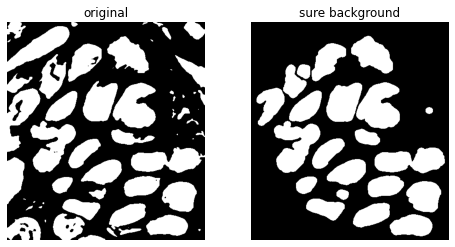

In [25]:
plot_comparison(inverted, sure_bg, 'sure background')

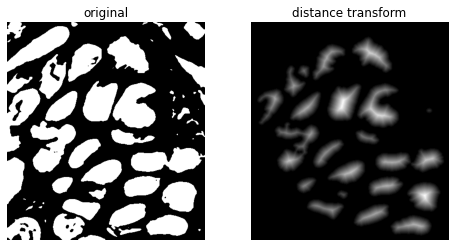

In [26]:
plot_comparison(inverted, dist_transform, 'distance transform')

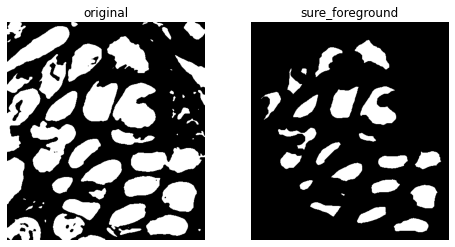

In [27]:
plot_comparison(inverted, sure_fg, 'sure_foreground')

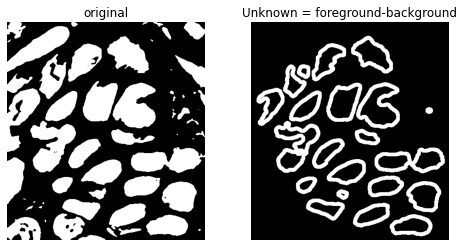

In [28]:
plot_comparison(inverted, unknown, 'Unknown = foreground-background')

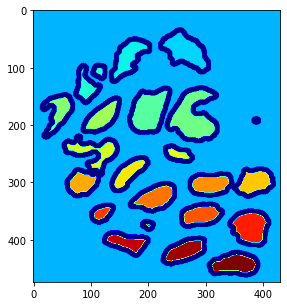

In [29]:
plt.rcParams['figure.figsize'] = 5,5

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers, cmap='jet')

In [30]:
img = cv2.imread("Abnormal variation in nuclear shape/1.png")

markers = cv2.watershed(img,markers)

#Let us color boundaries in yellow. 
#Remember that watershed assigns boundaries a value of -1 

In [31]:
img[markers == -1] = [0,255,255] 

In [32]:
#label2rgb - Return an RGB image where color-coded labels are painted over the image.
from skimage import color

img2 = color.label2rgb(markers, bg_label=0)

In [33]:
cv2.imshow('Overlay on original image', img)
cv2.imshow('Colored Grains', img2)
cv2.waitKey(0)

18